# Programming Project 9: Implement CUDA Count3s


name: Jameson Jolley<br>
date: dec 5 2025 
___

# intro 


In this assignment, we are investigating CUDA and comparing it to normal parallelism. CUDA, which stands for Compute Unified Device Architecture, is a parallel computing platform and application programming interface (API) model created by NVIDIA. It was officially released in 2007 and is used for programming on a GPU
___

# methods

For these experiments, we will make graphs of performance for array sizes of 100K, 1M, 10M, and 100M, and for thread/process counts of 64, 128, 256, 512, and 1024. We used the code from before and modified it to have the CUDA count. We then store the time in a CSV file and use matplotlib to plot the standard deviation. The experiment was run on the Allen host in the cs domain. 

In the instructions, you recommended using a results array. I didn't do that, I used the atomic add. Also, I used 2 different kernels and compared them; one of them, I restricted the number of blocks to 1. I did this because I wanted to see the impact of only using the same number of threads or just blasting it with as many blocks as possible. My prediction is that this will be very fast, and the unrestricted version, where we can have any number of blocks, will be the fastest (because it has more threads). I also predict that before a specific size of N, the performance will be slower.

I did test if the the results will be the same with all the different methods, but there is a small error in the normal threaded functions. 

Sample of the error:
<pre>
Error: results do not match! Serial: 9086941, Threaded: 9086918, GPU: 9086941 , GPU 1b: 9086941
Completed:      threads=1024    n=100000000     trial=3
Error: results do not match! Serial: 9093811, Threaded: 9093790, GPU: 9093811 , GPU 1b: 9093811
Completed:      threads=1024    n=100000000     trial=4
Error: results do not match! Serial: 9089932, Threaded: 9089905, GPU: 9089932 , GPU 1b: 9089932
</pre>
This does not happen for all the runs, and I could not find the bug in time, but you can see that the other methods are correct. i think it is just a rase condition so i proseeded with the tests


The data files are represented with the following names:
<pre>
CUDA with the 1 block restriction    -> cuda_data_1b.csv
CUDA without the block restriction   -> cuda_data.csv
Tredded count 3 with padding of 16   -> thread_data16.csv
serial count 3 		             -> Serial_data.csv
</pre>
___

# data 

<Figure size 1200x800 with 0 Axes>

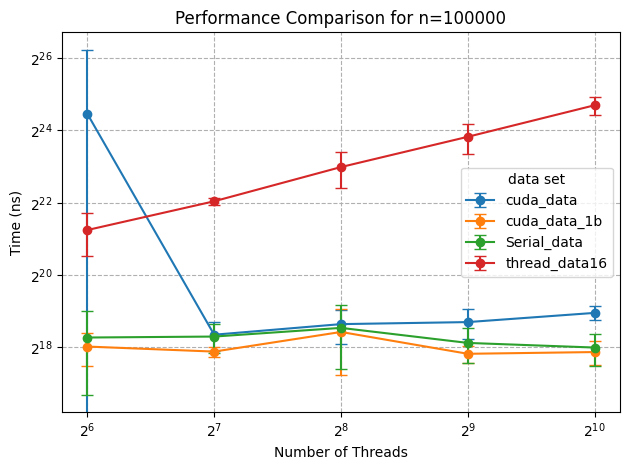

<Figure size 1200x800 with 0 Axes>

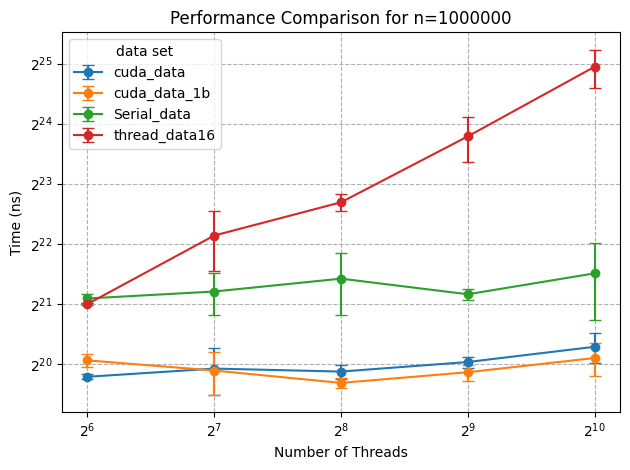

<Figure size 1200x800 with 0 Axes>

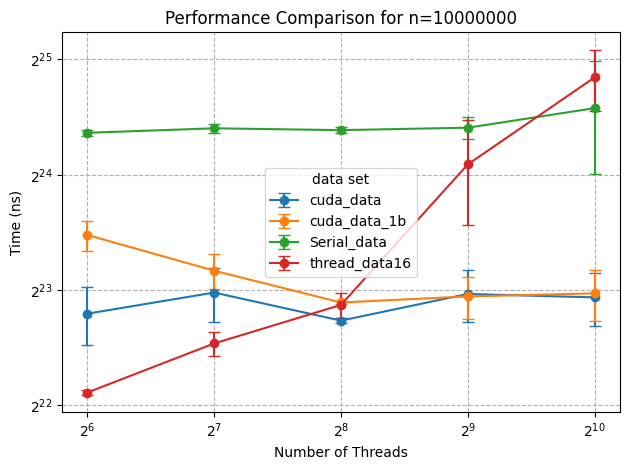

<Figure size 1200x800 with 0 Axes>

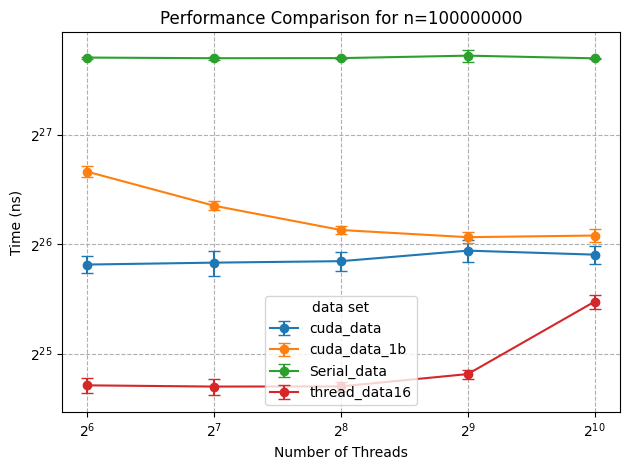

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
csv_files = ['cuda_data.csv',
             "cuda_data_1b.csv",
'Serial_data.csv',
'thread_data16.csv',
]
for csv_file in csv_files: # we loop over them
    df = pd.read_csv(csv_file) # load them into a data frame
    sizes_of_n = df['size of n'].unique() # removes dups or removes the cartesian p
# List of problem sizes (n values) to plot
n_values = sizes_of_n
for n_val in n_values:
    plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots()
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        label = os.path.splitext(os.path.basename(csv_file))[0]
        grouped = df.groupby(['size of n', 'number of threads'])['time in ns']
        mean = grouped.mean().reset_index()
        std = grouped.std().reset_index()
        mask = mean['size of n'] == n_val
        threads = mean.loc[mask, 'number of threads']
        avg = mean.loc[mask, 'time in ns']
        error = std.loc[mask, 'time in ns']
       
        ax.errorbar(
            threads,
            avg,
            yerr=error,
            marker='o',
            capsize=4,
            label=label
        )
        
    ax.set_xlabel('Number of Threads')
    ax.set_ylabel('Time (ns)')
    ax.set_title(f'Performance Comparison for n={n_val}')
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.legend(title='data set')
    ax.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

# conclusion


As shown in the graphs, what I predicted was wrong. The fastest one was the threaded one, which far exceeds the performance of the other solutions at a large n. The situation is different with moderate N, where the CUDA solutions are better than anything else, and the 2 different methods for the kernels are not much different. 
___

# appendix



In [ ]:
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <sys/types.h>      /* key_t, sem_t, pid_t      */
#include <sys/wait.h>
#include <sys/shm.h>        /* shmat(), IPC_RMID        */
#include <errno.h>          /* errno, ECHILD            */
#include <semaphore.h>      /* sem_open(), sem_destroy(), sem_wait().. */
#include <fcntl.h>          /* O_CREAT, O_EXEC          */

#include <sys/mman.h>    /* New for shared memory */
#include <unistd.h>   /* to have fork() */
#include <pthread.h>

sem_t *sem;                   /*      synch semaphore         *//*shared */
int *pcount;
//macro to measure time taken by a block of code
// usage: MAKE_TIME_MEASUREMENT( code );
// the time taken will be stored in the variable time_taken
#define START_TIMER(start_ts) \
    if (clock_gettime(CLOCK_MONOTONIC, &(start_ts)) == -1) { \
        perror("clock_gettime START"); \
        exit(EXIT_FAILURE); \
    }

#define STOP_TIMER_NS(start_ts, end_ts, result_ns) \
    if (clock_gettime(CLOCK_MONOTONIC, &(end_ts)) == -1) { \
        perror("clock_gettime END"); \
        exit(EXIT_FAILURE); \
    } \
    (result_ns) = ((end_ts.tv_sec - start_ts.tv_sec) * 1000000000LL) + \
                  (end_ts.tv_nsec - start_ts.tv_nsec);

long long time_taken;
struct timespec start, end;
#define MAKE_TIME_MEASUREMENT(code) \
    START_TIMER(start) \
    code \
    STOP_TIMER_NS(start,end,time_taken) \




typedef struct config { //struct to hold command line arguments
    int num_threads;
    int num_count;
    int range;
    int seed;
    int padding;
    int collect_data;
    int block_size;
}config_t;

typedef struct args{
    int *array;
    int start;
    int size;
    int value;
    int result;
    int padding; // should be null for the most part.
} args_t;
pthread_mutex_t my_mutex; // Declaration
int Global_count = 0;

void print_config(config_t *config){
    printf("Number of threads/prosses: %d\n", config->num_threads);
    printf("Number of random numbers to generate: %d\n", config->num_count);
    printf("Range of random numbers:  X mod %d\n", config->range);
    printf("Seed for random number generator: %d\n", config->seed);
    printf("Padding to avoid false sharing: %d\n", config->padding);
    if(config->collect_data > 0){
        printf("Data collection: ON\n");
    }else{
        printf("Data collection: OFF\n");   
    }
    printf("Block size for CUDA kernels: %d\n", config->block_size);
}

//function to count the number of times a value appears in an array
//this is more general than the book's version which only counts 3s 
// in the whole array this is for a subarray defined by start and size
// doing it this way will make it easier to parallelize later
int count_int_in_range(int *array,int start,int size, int value){
    int count = 0;
    int i = start;
    int end = start + size;
    do{
        if(array[i++] == value){
            ++count;
        }
    }while(i < end);
    return count;
}

/*
    this function parses the command line arguments and returns a config struct
    if an invalid argument is passed, the program will print an error message and exit
*/
config_t *parse_args(int argc, char *argv[]){
    config_t *config = (config_t *)malloc(sizeof(config_t));
    //default values
    config->num_threads = 1;
    config->num_count = 1000000;
    config->range = 10;//this is inclusive so the random numbers will be between 0 and range
    config->seed = time(NULL);
    config->padding = 0;

    for(int i=0; i<argc; i++){ //iterate through all arguments
        if(argv[i][0] == '-'){
            switch(argv[i][1]){ //check the character after the '-'
                case 't':
                    //number of threads
                    config->num_threads = atoi(argv[i+1]);
                    i++;
                    break;
                case 'n':
                    //number of random numbers to generate
                    config->num_count = atoi(argv[i+1]);
                    i++;
                    break;
                case 'r':
                    //range of random numbers
                    config->range = atoi(argv[i+1]);
                    i++;
                    break;
                case 's':
                    //seed for random number generator
                    config->seed = atoi(argv[i+1]);
                    i++;
                    break;
                case 'p':
                    config->padding = atoi(argv[i+1]);
                    i++;
                    //padding to avoid false sharing
                    break;
                case 'c':
                    // we run the data collections
                    config->collect_data = 1;
                    break;
                case 'b':
                    // we run the data collections
                    config->block_size = atoi(argv[i+1]);
                    i++;
                    break;
                default:
                    printf("Invalid argument: %s\n", argv[i]);
                    exit(1);
            }
        }
    }
    config->range += 1; //make range inclusive
    return config;
};

// this one is the cuda kernel to count the number of times a value appears in an array
// this is more general than the book's version which only counts 3s 
// we use a singel block for comparison with the cpu version
// each thread will check one element of the array
__global__ void count_int_in_range_cuda_singel_block(int *array, int size, int value, int *result){
    int idx = blockIdx.x * blockDim.x + threadIdx.x; // get the idx of the thread
    int step = blockDim.x * gridDim.x; // calculate the step size
    int local_count = 0;
    for(int i = idx; i < size; i += step){ // loop through the array
        if(array[i] == value){
            local_count++; 
        }
    }
    atomicAdd(result, local_count); // add the local count to the global count
}

__global__ void count_int_in_range_cuda(int *array, int size, int value, int *result){
    int idx = blockIdx.x * blockDim.x + threadIdx.x; // get the idx of the thread
    if(idx >= size) return; // we are outside the array
    if(array[idx] != value) return;
    atomicAdd(result, 1);
}

void gpu_count_single_block(config_t *config, int *array, int size, int value, int *result){
    int *d_array;
    int *d_result;
    int h_result = 0;
    cudaMalloc((void **)&d_array, size * sizeof(int)); // allocate memory on the device
    cudaMalloc((void **)&d_result, sizeof(int)); // allocate memory for result on the device
    cudaMemcpy(d_array, array, size * sizeof(int), cudaMemcpyHostToDevice); // copy array to device
    cudaMemcpy(d_result, &h_result, sizeof(int), cudaMemcpyHostToDevice);   // copy result to device

    int block_size = config->block_size; // get block size from config
    int num_blocks = 1; // single block

    count_int_in_range_cuda_singel_block<<<num_blocks, block_size>>>(d_array, size, value, d_result);

    cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost);
    *result = h_result;

    cudaFree(d_array);
    cudaFree(d_result);

};



// this wrapper function for the cuda kernel
// will be called in the main function when we want to use cuda
// this is to deal with cuda specific memory management
// and kernel launch parameters
void gpu_count(config_t *config, int *array, int size, int value, int *result){
    int *d_array;
    int *d_result;
    int h_result = 0;
    cudaMalloc((void **)&d_array, size * sizeof(int)); // allocate memory on the device
    cudaMalloc((void **)&d_result, sizeof(int)); // allocate memory for result on the device
    cudaMemcpy(d_array, array, size * sizeof(int), cudaMemcpyHostToDevice); // copy array to device
    cudaMemcpy(d_result, &h_result, sizeof(int), cudaMemcpyHostToDevice);   // copy result to device

    int block_size = config->block_size; // get block size from config
    int num_blocks = (size + block_size - 1) / block_size; // calculate number of blocks needed

    count_int_in_range_cuda<<<num_blocks, block_size>>>(d_array, size, value, d_result);

    cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost);
    *result = h_result;

    cudaFree(d_array);
    cudaFree(d_result);

};


void *Threaded_count_function(void* args){
    args_t *args_cast = (args_t *)args;
    int local = 0;
    int i = args_cast->start;
    int end = args_cast->start + args_cast->size;
    do{
        if(args_cast->array[i++] == args_cast->value){
            local++;
        }
    }while(i < end);
    pthread_mutex_lock(&my_mutex);
        Global_count+= local;
    pthread_mutex_unlock(&my_mutex);
    return NULL;
};

// defalt general threading function that we will switch with different thread functions
void threded_count_int_in_range(int *array, config_t *config, int value){
    Global_count = 0;//set this to 0 
    pthread_t threads[config->num_threads];

    args_t *args = (args_t *)malloc(sizeof(args_t) * config->num_threads);
    args_t *args_padded = (args_t *)malloc(sizeof(args_t) * config->num_threads * config->padding);
    for(int i=0; i<config->num_threads; i++){
        //create threads and pass them the args struct
        args[i].array = array;
        args[i].start = i * (config->num_count / config->num_threads);
        args[i].size = config->num_count / config->num_threads;
        args[i].value = value;
        args[i].result = 0;
        if(config->padding >1){
            int d = i*config->padding;
            args_padded[d].array = array;
            args_padded[d].start = i * (config->num_count / config->num_threads);
            args_padded[d].size = config->num_count / config->num_threads;
            args_padded[d].value = value;
            args_padded[d].result = 0;
        }
        //create thread
        if(config->padding > 1){
            pthread_create(&threads[i], NULL, Threaded_count_function, (void *)&args_padded[i*config->padding]);
        }else{
            pthread_create(&threads[i], NULL, Threaded_count_function, (void *)&args[i]);
        }
    }
    for(int i=0; i<config->num_threads; i++){
        //join threads
        pthread_join(threads[i], NULL);
    }
    free(args);
    free(args_padded);

}


void make_data(config_t *config){
 
    printf("making the data.... (data will be saved in .csv files)\n");

    FILE *Serial_data = fopen("Serial_data.csv","w");
    fprintf(Serial_data,"size of n,number of threads,time in ns\n");

    FILE *cuda_data = fopen("cuda_data.csv","w");
    fprintf(cuda_data,"size of n,number of threads,time in ns\n");

    FILE *cuda_data_1b = fopen("cuda_data_1b.csv","w");
    fprintf(cuda_data_1b,"size of n,number of threads,time in ns\n");

    FILE *thread_data_16 = fopen("thread_data16.csv","w");
    fprintf(thread_data_16,"size of n,number of threads,time in ns\n");
    
    int arrsize[4] = {100000 , 1000000, 10000000, 100000000};
    for(int thread = 64 ; thread <= 1024 ; thread*=2 ){
        for(int i=0;i < 4; i++ ){//loops though the arr for the size of n
            for(int r=0; r<6;r++){
                  config->num_threads = thread;
                  config->num_count = arrsize[i];
                  int *random_numbers = (int *)malloc(sizeof(int) * config->num_count);
                  for (int i = 0; i < config->num_count; i++) {
                       random_numbers[i] = rand() % config->range;
                   }
                  MAKE_TIME_MEASUREMENT(int res1 = count_int_in_range(random_numbers,0,arrsize[i], 3);)
                  fflush(Serial_data);
                  fprintf(Serial_data,"%d,%d,%lld\n",arrsize[i],thread,time_taken);
                  fflush(thread_data_16);
                  MAKE_TIME_MEASUREMENT(threded_count_int_in_range(random_numbers,config,3);) // the result is in Global_count
                  fprintf(thread_data_16 ,"%d,%d,%lld\n",arrsize[i],thread,time_taken);
                  int res_gpu = 0;
                  fflush(cuda_data);
                  config->block_size=thread;
                  MAKE_TIME_MEASUREMENT(gpu_count( config, random_numbers, arrsize[i], 3, &res_gpu);)
                  fprintf(cuda_data,"%d,%d,%lld\n",arrsize[i],thread,time_taken);

                    int res_gpu_1b = 0;
                     fflush(cuda_data_1b);
                  MAKE_TIME_MEASUREMENT(gpu_count_single_block( config, random_numbers, arrsize[i], 3, &res_gpu_1b);)
                  fprintf(cuda_data_1b,"%d,%d,%lld\n",arrsize[i],thread,time_taken);
                   if(res1 != Global_count || res1 != res_gpu || res1 != res_gpu_1b){
                       printf("Error: results do not match! Serial: %d, Threaded: %d, GPU: %d , GPU 1b: %d\n", res1, Global_count, res_gpu, res_gpu_1b);
                   }
                   printf("Completed:\tthreads=%d\tn=%d\ttrial=%d\n",thread,arrsize[i],r);
            }
        }
    }
   //fclose(fork_data);
}







//command line arguments
/*
-t the number of threads to use
-n the number of random numbers to generate
-r the range of the random numbers (0 to r) inclusive
-s the seed for the random number generator
-h print a help message
-p padding to avoid false sharing
-c collects data
*/
int main(int argc , char *argv[]) {
    
    config_t *config = parse_args(argc, argv); //parse command line arguments
    print_config(config);
    if(config->collect_data > 0){
        make_data(config);
    }
    return 0;
}


# ploting code

# cuda_data.csv

In [ ]:
size of n,number of threads,time in ns
100000,64,137010969
100000,64,270906
100000,64,261008
100000,64,249813
100000,64,241749
100000,64,241033
1000000,64,955426
1000000,64,902412
1000000,64,905108
1000000,64,886412
1000000,64,884804
1000000,64,883538
10000000,64,6667552
10000000,64,6650411
10000000,64,6679102
10000000,64,7014922
10000000,64,6815497
10000000,64,9821100
100000000,64,64949638
100000000,64,58457013
100000000,64,57188031
100000000,64,57180753
100000000,64,56178466
100000000,64,59940832
100000,128,504265
100000,128,342789
100000,128,327699
100000,128,322668
100000,128,248861
100000,128,262983
1000000,128,1508730
1000000,128,983602
1000000,128,920132
1000000,128,880539
1000000,128,848322
1000000,128,814136
10000000,128,6753339
10000000,128,9499911
10000000,128,9191468
10000000,128,7102757
10000000,128,9706293
10000000,128,7304190
100000000,128,57114512
100000000,128,58373163
100000000,128,56280201
100000000,128,56931103
100000000,128,68652639
100000000,128,60845561
100000,256,479484
100000,256,268735
100000,256,303211
100000,256,580471
100000,256,320128
100000,256,509358
1000000,256,984466
1000000,256,940177
1000000,256,870282
1000000,256,1073574
1000000,256,1014293
1000000,256,871257
10000000,256,6908943
10000000,256,6935857
10000000,256,7139915
10000000,256,6882968
10000000,256,7026774
10000000,256,6966075
100000000,256,57295262
100000000,256,61236138
100000000,256,58476962
100000000,256,59470195
100000000,256,58101638
100000000,256,66962257
100000,512,655179
100000,512,427898
100000,512,339252
100000,512,390446
100000,512,335692
100000,512,410556
1000000,512,1114491
1000000,512,1024899
1000000,512,1008941
1000000,512,1036752
1000000,512,1191093
1000000,512,1048422
10000000,512,7020125
10000000,512,9856509
10000000,512,7526855
10000000,512,7112880
10000000,512,7903914
10000000,512,9722826
100000000,512,60206116
100000000,512,68444966
100000000,512,61507092
100000000,512,69068410
100000000,512,67428324
100000000,512,59834070
100000,1024,525655
100000,1024,440669
100000,1024,611974
100000,1024,545184
100000,1024,489194
100000,1024,439483
1000000,1024,1202616
1000000,1024,1226437
1000000,1024,1706524
1000000,1024,1152005
1000000,1024,1180302
1000000,1024,1192669
10000000,1024,7110384
10000000,1024,7332583
10000000,1024,9429304
10000000,1024,7199926
10000000,1024,7189093
10000000,1024,9882989
100000000,1024,65791860
100000000,1024,58451695
100000000,1024,60102704
100000000,1024,62161089
100000000,1024,62050479
100000000,1024,68244542


# cuda_data_1b.csv

In [ ]:
size of n,number of threads,time in ns
100000,64,433258
100000,64,234588
100000,64,230542
100000,64,229671
100000,64,244788
100000,64,228386
1000000,64,1233858
1000000,64,1044167
1000000,64,1148979
1000000,64,1033442
1000000,64,1033911
1000000,64,1054963
10000000,64,11184877
10000000,64,11269293
10000000,64,11231695
10000000,64,11242487
10000000,64,11327254
10000000,64,13812550
100000000,64,111438172
100000000,64,109824592
100000000,64,103295716
100000000,64,102845963
100000000,64,103564036
100000000,64,106132827
100000,128,263504
100000,128,258242
100000,128,238084
100000,128,260521
100000,128,204894
100000,128,228966
1000000,128,1442562
1000000,128,949257
1000000,128,887970
1000000,128,863366
1000000,128,860270
1000000,128,820762
10000000,128,8336580
10000000,128,10148948
10000000,128,10090324
10000000,128,8420459
10000000,128,10576772
10000000,128,8954721
100000000,128,86471999
100000000,128,88798342
100000000,128,82189009
100000000,128,86569292
100000000,128,86235344
100000000,128,83301544
100000,256,203010
100000,256,197177
100000,256,715715
100000,256,384093
100000,256,224480
100000,256,393406
1000000,256,817930
1000000,256,816597
1000000,256,832161
1000000,256,938465
1000000,256,834793
1000000,256,809294
10000000,256,7732301
10000000,256,7862336
10000000,256,7694923
10000000,256,7792116
10000000,256,7746639
10000000,256,7861147
100000000,256,75462914
100000000,256,74829987
100000000,256,71630582
100000000,256,72070339
100000000,256,71564203
100000000,256,74834397
100000,512,301283
100000,512,245199
100000,512,211599
100000,512,217164
100000,512,209604
100000,512,209354
1000000,512,922918
1000000,512,1081027
1000000,512,898728
1000000,512,883875
1000000,512,1045864
1000000,512,878723
10000000,512,7239956
10000000,512,9618109
10000000,512,7362123
10000000,512,7348091
10000000,512,7789651
10000000,512,9066720
100000000,512,73578609
100000000,512,69381602
100000000,512,72506408
100000000,512,66664743
100000000,512,69225843
100000000,512,69489710
100000,1024,212686
100000,1024,229126
100000,1024,219545
100000,1024,350809
100000,1024,212824
100000,1024,216495
1000000,1024,1020972
1000000,1024,1040166
1000000,1024,1527612
1000000,1024,974002
1000000,1024,1027370
1000000,1024,1139294
10000000,1024,7358579
10000000,1024,7577395
10000000,1024,9660779
10000000,1024,7356118
10000000,1024,7402533
10000000,1024,9972267
100000000,1024,68872966
100000000,1024,70195836
100000000,1024,75586694
100000000,1024,72835214
100000000,1024,69118112
100000000,1024,68634933


# thread_data16.csv

In [ ]:
size of n,number of threads,time in ns
100000,64,4498617
100000,64,2229836
100000,64,2136915
100000,64,2026060
100000,64,2013689
100000,64,2022347
1000000,64,2078883
1000000,64,2110790
1000000,64,2069332
1000000,64,2133000
1000000,64,2076813
1000000,64,2069359
10000000,64,4484574
10000000,64,4534867
10000000,64,4523347
10000000,64,4647294
10000000,64,4503135
10000000,64,4472957
100000000,64,28051041
100000000,64,25418488
100000000,64,28384950
100000000,64,28679864
100000000,64,27719787
100000000,64,26448270
100000,128,3957925
100000,128,4465346
100000,128,4557489
100000,128,4740771
100000,128,4063972
100000,128,4111208
1000000,128,7708564
1000000,128,4413838
1000000,128,3992945
1000000,128,3804819
1000000,128,3813323
1000000,128,3916826
10000000,128,5438768
10000000,128,6310353
10000000,128,5701754
10000000,128,6605217
10000000,128,6323132
10000000,128,6114765
100000000,128,26698237
100000000,128,28161486
100000000,128,25013667
100000000,128,26613694
100000000,128,28774297
100000000,128,28157339
100000,256,6048365
100000,256,6356081
100000,256,6160886
100000,256,13034462
100000,256,8918671
100000,256,9356289
1000000,256,6758310
1000000,256,6746927
1000000,256,6788434
1000000,256,7939126
1000000,256,6477264
1000000,256,5877611
10000000,256,6948402
10000000,256,6962116
10000000,256,8103849
10000000,256,8176397
10000000,256,7908603
10000000,256,7915801
100000000,256,27112587
100000000,256,27018738
100000000,256,26786053
100000000,256,28590716
100000000,256,26210727
100000000,256,27885600
100000,512,22373927
100000,512,17088730
100000,512,12568580
100000,512,12312257
100000,512,12255295
100000,512,12468180
1000000,512,12876315
1000000,512,12448993
1000000,512,12493307
1000000,512,14888712
1000000,512,21803796
1000000,512,12359177
10000000,512,13190779
10000000,512,25017197
10000000,512,18526270
10000000,512,13209956
10000000,512,23698041
10000000,512,13485209
100000000,512,29721141
100000000,512,29807947
100000000,512,28723013
100000000,512,28182157
100000000,512,29936759
100000000,512,30521982
100000,1024,24676378
100000,1024,24211644
100000,1024,25349473
100000,1024,36448355
100000,1024,27043650
100000,1024,25234638
1000000,1024,26314109
1000000,1024,40845645
1000000,1024,35356175
1000000,1024,26075155
1000000,1024,25877599
1000000,1024,39519118
10000000,1024,26321806
10000000,1024,27434206
10000000,1024,33470018
10000000,1024,26999888
10000000,1024,26662187
10000000,1024,39893142
100000000,1024,46388258
100000000,1024,45650561
100000000,1024,48764992
100000000,1024,48589875
100000000,1024,47272546
100000000,1024,43152445


# Serial_data.csv

In [ ]:
size of n,number of threads,time in ns
100000,64,746726
100000,64,201539
100000,64,226243
100000,64,233009
100000,64,225605
100000,64,270979
1000000,64,2328401
1000000,64,2166730
1000000,64,2156471
1000000,64,2327363
1000000,64,2048532
1000000,64,2349341
10000000,64,21191303
10000000,64,21368505
10000000,64,21521946
10000000,64,21744463
10000000,64,22238691
10000000,64,21467325
100000000,64,217796625
100000000,64,217580201
100000000,64,221076024
100000000,64,217927515
100000000,64,218746703
100000000,64,219312131
100000,128,489210
100000,128,322784
100000,128,310742
100000,128,325685
100000,128,237150
100000,128,254024
1000000,128,2031492
1000000,128,3545174
1000000,128,2134388
1000000,128,2074735
1000000,128,2350504
1000000,128,2357214
10000000,128,23150811
10000000,128,22356718
10000000,128,21467682
10000000,128,21560274
10000000,128,22575629
10000000,128,21978731
100000000,128,221131729
100000000,128,218767378
100000000,128,215846587
100000000,128,217436360
100000000,128,217087321
100000000,128,216651612
100000,256,237830
100000,256,256315
100000,256,260643
100000,256,769249
100000,256,461779
100000,256,304407
1000000,256,2339818
1000000,256,2357673
1000000,256,2193012
1000000,256,4578752
1000000,256,3276849
1000000,256,2067169
10000000,256,21882492
10000000,256,22466222
10000000,256,21577421
10000000,256,21526136
10000000,256,22052427
10000000,256,22121672
100000000,256,216611728
100000000,256,218287333
100000000,256,216838690
100000000,256,220615040
100000000,256,217175718
100000000,256,218258967
100000,512,209722
100000,512,450064
100000,512,334751
100000,512,226199
100000,512,236171
100000,512,260195
1000000,512,2226134
1000000,512,2368187
1000000,512,2361223
1000000,512,2585099
1000000,512,2323134
1000000,512,2178050
10000000,512,21921513
10000000,512,21579572
10000000,512,25085302
10000000,512,21283175
10000000,512,21283549
10000000,512,22421697
100000000,512,217029996
100000000,512,217948555
100000000,512,238998364
100000000,512,219049797
100000000,512,217112371
100000000,512,218244258
100000,1024,208540
100000,1024,226538
100000,1024,225643
100000,1024,235659
100000,1024,419821
100000,1024,255056
1000000,1024,3544543
1000000,1024,2055439
1000000,1024,2287001
1000000,1024,2351119
1000000,1024,2348173
1000000,1024,5292476
10000000,1024,22024074
10000000,1024,21592786
10000000,1024,41735804
10000000,1024,21623381
10000000,1024,21629622
10000000,1024,21626103
100000000,1024,217403359
100000000,1024,217198765
100000000,1024,217777984
100000000,1024,218292087
100000000,1024,216937906
100000000,1024,218455403
